In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGES_PATH = 'data/images/'

In [3]:
IMAGES_NAME = !ls ../data/images/
IMAGES_NAME

['TotoLeGPU1.jpg',
 'TotoLeGPU2.jpg',
 'TotoLeGPU3.jpg',
 'TotoLeGPU4.jpg',
 'TotoLeGPU5.jpg',
 'barcode-00-01.jpg',
 'barcode-00-02.jpg',
 'barcode-00-03.jpg',
 'barcode-09-01.jpg',
 'barcode-09-02.jpg',
 'barcode-09-03.jpg',
 'barcode-09-04.jpg',
 'barcode-09-05.jpg',
 'barcode-10-01.jpg',
 'barcode-10-02.jpg',
 'barcode-10-03.jpg',
 'barcode-10-04.jpg',
 'barcode-10-05.jpg',
 'barcode-68-01.jpg',
 'barcode-68-02.jpg',
 'barcode-68-03.jpg',
 'barcode-68-04.jpg',
 'barcode-68-05.jpg',
 'barcode-BOGGED-01.jpg',
 'barcode-BOGGED-02.jpg',
 'barcode-BOGGED-03.jpg',
 'barcode-BOGGED-04.jpg',
 'barcode-BOGGED-05.jpg',
 'barcode-GottaGoFast-01.jpg',
 'barcode-GottaGoFast-02.jpg',
 'barcode-GottaGoFast-03.jpg',
 'barcode-GottaGoFast-04.jpg',
 'barcode-GottaGoFast-05.jpg',
 'barcode-LesTangzouzes-01.jpg',
 'barcode-LesTangzouzes-02',
 'barcode-LesTangzouzes-03.jpg',
 'barcode-LesTangzouzes-04.jpg',
 'barcode-LesTangzouzes-05.jpg',
 'barcode-SequentialGPU-01.jpg',
 'barcode-SequentialGPU-02.jpg

In [4]:
images = [io.imread('../' + IMAGES_PATH + image_name) for image_name in IMAGES_NAME]

In [5]:
images = [np.array(image).mean(axis=2).astype(np.uint8) for image in images[:5]]

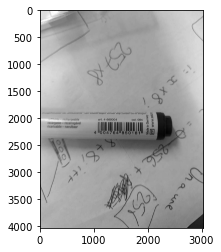

In [6]:
plt.imshow(images[0], cmap='gray')
plt.show()

In [7]:
all_tiles = []
for image in images:
    n_cols = len(image[0])
    n_rows = len(image)

    tiles = []

    for i in range(0, n_rows, 16):
        for j in range(0, n_cols, 16):
            tiles.append(image[i:i+16, j:j+16])
    all_tiles.append(tiles)

In [8]:
index_table = [(0, 2), (1, 2), (2, 2), (2, 1), (2, 0), (1, 0), (0, 0), (0, 1)]
padding_row = np.zeros(18).astype(np.uint8).tolist()

In [9]:
def compute_lbp_value(lbp_window):
    lbp_value = 0
    pixel_value = lbp_window[1][1]
    for i in range(8):
        row_index, col_index = index_table[i]
        lbp_value = lbp_value | (int(lbp_window[row_index][col_index] >= pixel_value) << i)
        
    return lbp_value

In [10]:
def pad_tile(tile):
    tileList = tile.tolist()
    
    for i in range(16):
        tileList[i].insert(0, 0)
        tileList[i].append(0)
    tileList.insert(0, padding_row)
    tileList.append(padding_row)    
    return np.array(tileList)

In [11]:
all_histo = []
for tiles in all_tiles:
    histo_list = []
    for tile in tiles:
        padded_tile = pad_tile(tile)
        lbp_histo = [0 for i in range(256)]
    
        for i in range(1, 17):
            for j in range(1, 17):
                window = padded_tile[i-1:i+2, j-1:j+2]
                lbp_histo[compute_lbp_value(window)] += 1    
            
        histo_list.append(lbp_histo) # / np.max(lbp_histo))
    
    all_histo.append(histo_list)
    

In [12]:
all_histo = np.array(all_histo)
all_histo.shape

(5, 47628, 256)

In [13]:
all_histo_reshaped = all_histo.reshape((-1, 256))

In [14]:
from sklearn.cluster import KMeans

In [15]:
n_cluster=16

In [16]:
kmeans = KMeans(n_clusters=n_cluster, random_state=128).fit(all_histo_reshaped)

In [18]:
import pandas as pd

pd.DataFrame(kmeans.cluster_centers_).to_csv("../data/centroids.csv", header=None, index=None)